In [1]:
# Load required packages
import pycisTopic
import pandas as pd
import pyranges as pr
pycisTopic.__version__

'1.0a0'

In [5]:
import pandas as pd
cell_data = pd.read_table("pancreas_meso.tsv", index_col = 0)
cell_data.head()
cell_data['sample_id'] = 'pancreas'

,cell_type
AAACGAAGTTCTTAGG-1,pancreas_mesothelium
AAACGAATCTGGCGCA-1,pancreas_mesothelium
AAACTCGCAGTAACTC-1,pancreas_mesothelium
AAACTGCCAAGTAATG-1,pancreas_mesothelium
AAACTGCGTTCTGATG-1,pancreas_mesothelium


In [7]:
cell_data2 = pd.read_table("lung_meso.tsv", index_col = 0)
cell_data2.head()
cell_data2['sample_id'] = 'lung'

,cell_type
AAACTCGCATGGTATC-1,lung_mesothelium
AAACTCGCATTACCTT-1,lung_mesothelium
AAAGGATAGACTTCCA-1,lung_mesothelium
AAAGGGCAGCAATAAC-1,lung_mesothelium
AAAGGGCCAACTAGAA-1,lung_mesothelium


In [9]:
cell_data3 = pd.read_table("heart_meso.tsv", index_col = 0)
cell_data3.head()
cell_data3['sample_id'] = 'heart'

,cell_type
E13_5_1,heart_mesothelium
E13_5_10,heart_mesothelium
E13_5_100,heart_mesothelium
E13_5_101,heart_mesothelium
E13_5_102,heart_mesothelium


In [13]:
# create a merged dataframe that will be used to annotate the cistopic object
pieces = (cell_data, cell_data2, cell_data3)
df_final = pd.concat(pieces)
df_final

,cell_type,sample_id
AAACGAAGTTCTTAGG-1,pancreas_mesothelium,pancreas
AAACGAATCTGGCGCA-1,pancreas_mesothelium,pancreas
AAACTCGCAGTAACTC-1,pancreas_mesothelium,pancreas
AAACTGCCAAGTAATG-1,pancreas_mesothelium,pancreas
AAACTGCGTTCTGATG-1,pancreas_mesothelium,pancreas
...,...,...
E13_5_95,heart_mesothelium,heart
E13_5_96,heart_mesothelium,heart
E13_5_97,heart_mesothelium,heart
E13_5_98,heart_mesothelium,heart


In [14]:
# Prepare a dataframe with mm10 chromosome size
chromsizes = pd.read_table(
    "http://hgdownload.cse.ucsc.edu/goldenPath/mm10/bigZips/mm10.chrom.sizes",
    header = None,
    names = ["Chromosome", "End"]
)
chromsizes.insert(1, "Start", 0)
chromsizes.head()

,Chromosome,Start,End
0,chr1,0,195471971
1,chr2,0,182113224
2,chrX,0,171031299
3,chr3,0,160039680
4,chr4,0,156508116


In [15]:
fragments_dict = {'heart': '/mnt/sdb/qdang/atac/pycisTopic/E135_fragments.tsv.gz',
                 'lung': '/mnt/sdb/qdang/meso_project/fragments/lung/fragments.tsv.gz',
                 'pancreas': '/mnt/sdb/qdang/meso_project/fragments/pancreas/fragments.tsv.gz'}

In [17]:
# Export pseudobulk bed and bigwig files for all organ mesothelia
from pycisTopic.pseudobulk_peak_calling import export_pseudobulk
bw_paths, bed_paths = export_pseudobulk(
    input_data = df_final,
    variable = "cell_type",
    chromsizes = chromsizes,
    bed_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bed_files"),
    bigwig_path = os.path.join(out_dir, "consensus_peak_calling/pseudobulk_bw_files"),
    path_to_fragments = fragments_dict,
    n_cpu = 30,
    normalize_bigwig = True,
    temp_dir = "/mnt/sdb/qdang/tmp",
    split_pattern = "-"
)

2024-06-18 10:46:24,161 cisTopic     INFO     Splitting fragments by cell type.
2024-06-18 10:46:43,944 cisTopic     INFO     generating bigwig files


In [18]:
with open(os.path.join(out_dir, "consensus_peak_calling/bw_paths.tsv"), "wt") as f:
    for v in bw_paths:
        _ = f.write(f"{v}\t{bw_paths[v]}\n")

In [19]:
with open(os.path.join(out_dir, "consensus_peak_calling/bed_paths.tsv"), "wt") as f:
    for v in bed_paths:
        _ = f.write(f"{v}\t{bed_paths[v]}\n")

In [34]:
# Perform MACS2 peak calling for lung and pancreas mesothelia
from pycisTopic.pseudobulk_peak_calling import peak_calling
macs_path = "macs2"

os.makedirs(os.path.join(out_dir, "consensus_peak_calling/MACS"), exist_ok = True)

narrow_peak_dict = peak_calling(
    macs_path = macs_path,
    bed_paths = bed_paths,
    outdir = os.path.join(os.path.join(out_dir, "consensus_peak_calling/MACS")),
    genome_size = 'mm',
    n_cpu = 30,
    input_format = 'BEDPE',
    shift = 73,
    ext_size = 146,
    keep_dup = 'all',
    q_value = 0.01,
    _temp_dir = '/mnt/sdb/qdang/tmp'
)

2024-06-18 11:23:14,382	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


(macs_call_peak_ray pid=458907) 2024-06-18 11:23:16,197 cisTopic     INFO     Calling peaks for heart_mesothelium with macs2 callpeak --treatment outs/consensus_peak_calling/pseudobulk_bed_files/heart_mesothelium.fragments.tsv.gz --name heart_mesothelium  --outdir outs/consensus_peak_calling/MACS --format BEDPE --gsize mm --qvalue 0.01 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=458888) 2024-06-18 11:23:16,222 cisTopic     INFO     Calling peaks for lung_mesothelium with macs2 callpeak --treatment outs/consensus_peak_calling/pseudobulk_bed_files/lung_mesothelium.fragments.tsv.gz --name lung_mesothelium  --outdir outs/consensus_peak_calling/MACS --format BEDPE --gsize mm --qvalue 0.01 --nomodel --shift 73 --extsize 146 --keep-dup all --call-summits --nolambda
(macs_call_peak_ray pid=458898) 2024-06-18 11:23:16,279 cisTopic     INFO     Calling peaks for pancreas_mesothelium with macs2 callpeak --treatment outs/consensus_peak_callin

In [35]:
narrow_peak_dict

{'pancreas_mesothelium': +--------------+-----------+-----------+-------+
 | Chromosome   | Start     | End       | +7    |
 | (category)   | (int64)   | (int64)   | ...   |
 |--------------+-----------+-----------+-------|
 | chr1         | 3449570   | 3449861   | ...   |
 | chr1         | 3477060   | 3477929   | ...   |
 | chr1         | 3477060   | 3477929   | ...   |
 | chr1         | 3514867   | 3515107   | ...   |
 | ...          | ...       | ...       | ...   |
 | chrY         | 90744276  | 90744570  | ...   |
 | chrY         | 90800504  | 90800727  | ...   |
 | chrY         | 90804985  | 90805300  | ...   |
 | chrY         | 90808771  | 90808926  | ...   |
 +--------------+-----------+-----------+-------+
 Unstranded PyRanges object has 109,480 rows and 10 columns from 21 chromosomes.
 For printing, the PyRanges was sorted on Chromosome.
 Considered unstranded due to these Strand values: '.'
 7 hidden columns: Name, Score, Strand, FC_summit, -log10_pval, ... (+ 2 more.),
 'lun

In [47]:
###Create a PyRanges object from ATAc-seq peaks (called from bulk ATAC-seq samples)
A = pd.read_csv("/mnt/sdb/qdang/atac/macs2_peakcalling/run2_652024/q_001/E135.mRp.clN_peaks.narrowPeak",sep="\t",header=None)
A.columns = [
            "Chromosome",
            "Start",
            "End",
            "Name",
            "Score",
            "Strand",
            "FC_summit",
            "-log10_pval",
            "-log10_qval",
            "Summit",
]
A = pr.PyRanges(narrow_peak)
print(A)

+--------------+-----------+-----------+---------------------------+-------+
| Chromosome   | Start     | End       | Name                      | +6    |
| (category)   | (int64)   | (int64)   | (object)                  | ...   |
|--------------+-----------+-----------+---------------------------+-------|
| chr1         | 3119598   | 3120788   | E135.mRp.clN_peak_1a      | ...   |
| chr1         | 3119598   | 3120788   | E135.mRp.clN_peak_1b      | ...   |
| chr1         | 3121241   | 3121747   | E135.mRp.clN_peak_2       | ...   |
| chr1         | 3164933   | 3165123   | E135.mRp.clN_peak_3       | ...   |
| ...          | ...       | ...       | ...                       | ...   |
| chrY         | 897596    | 898240    | E135.mRp.clN_peak_124532b | ...   |
| chrY         | 897596    | 898240    | E135.mRp.clN_peak_124532c | ...   |
| chrY         | 1009989   | 1010803   | E135.mRp.clN_peak_124533  | ...   |
| chrY         | 1245187   | 1246090   | E135.mRp.clN_peak_124534  | ...   |

In [50]:
# Combine all mesothelia into a single PyRanges object
narrow_peak_dict['heart_mesothelium'] = A
narrow_peak_dict

{'pancreas_mesothelium': +--------------+-----------+-----------+-------+
 | Chromosome   | Start     | End       | +7    |
 | (category)   | (int64)   | (int64)   | ...   |
 |--------------+-----------+-----------+-------|
 | chr1         | 3449570   | 3449861   | ...   |
 | chr1         | 3477060   | 3477929   | ...   |
 | chr1         | 3477060   | 3477929   | ...   |
 | chr1         | 3514867   | 3515107   | ...   |
 | ...          | ...       | ...       | ...   |
 | chrY         | 90744276  | 90744570  | ...   |
 | chrY         | 90800504  | 90800727  | ...   |
 | chrY         | 90804985  | 90805300  | ...   |
 | chrY         | 90808771  | 90808926  | ...   |
 +--------------+-----------+-----------+-------+
 Unstranded PyRanges object has 109,480 rows and 10 columns from 21 chromosomes.
 For printing, the PyRanges was sorted on Chromosome.
 Considered unstranded due to these Strand values: '.'
 7 hidden columns: Name, Score, Strand, FC_summit, -log10_pval, ... (+ 2 more.),
 'lun

In [51]:
# Perform consensus peak calling of all organ mesothelia
from pycisTopic.iterative_peak_calling import get_consensus_peaks
peak_half_width=250
path_to_blacklist="/mnt/sdb/qdang/reference/mouse/mm10-blacklist.v2.bed"
# Get consensus peaks
consensus_peaks = get_consensus_peaks(
    narrow_peaks_dict = narrow_peak_dict2,
    peak_half_width = peak_half_width,
    chromsizes = chromsizes,
    path_to_blacklist = path_to_blacklist)

2024-06-18 11:52:17,902 cisTopic     INFO     Extending and merging peaks per class
2024-06-18 11:52:38,951 cisTopic     INFO     Normalizing peak scores
2024-06-18 11:52:39,066 cisTopic     INFO     Merging peaks
2024-06-18 11:53:06,486 cisTopic     INFO     Done!


In [52]:
# save consensus peaks
consensus_peaks.to_bed(
    path = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed"),
    keep =True,
    compression = 'infer',
    chain = False)

In [54]:
# Create cistopic object
path_to_regions = os.path.join(out_dir, "consensus_peak_calling/consensus_regions.bed")
# Blacklist
path_to_blacklist = '/mnt/sdb/qdang/reference/mouse/mm10-blacklist.v2.bed'
#Create objects
from pycisTopic.cistopic_class import *
cistopic_obj_list=[create_cistopic_object_from_fragments(path_to_fragments=fragments_dict[key],
                                               path_to_regions=path_to_regions,
                                               path_to_blacklist=path_to_blacklist,
                                               valid_bc=None,
                                               n_cpu=15,
                                               project=key,
                                               split_pattern='-') for key in fragments_dict.keys()]

2024-06-18 11:54:26,639 cisTopic     INFO     Reading data for heart
2024-06-18 11:54:34,105 cisTopic     INFO     Counting number of unique fragments (Unique_nr_frag)
2024-06-18 11:54:36,493 cisTopic     INFO     Counting fragments in regions


2024-06-18 11:54:39,578	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2024-06-18 11:54:44,642 cisTopic     INFO     Creating fragment matrix
2024-06-18 11:54:46,913 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-06-18 11:54:47,303 cisTopic     INFO     Removing blacklisted regions
2024-06-18 11:54:47,756 cisTopic     INFO     Creating CistopicObject
2024-06-18 11:54:48,086 cisTopic     INFO     Done!
2024-06-18 11:54:48,097 cisTopic     INFO     Reading data for lung
2024-06-18 11:54:52,251 cisTopic     INFO     Counting number of unique fragments (Unique_nr_frag)
2024-06-18 11:54:53,400 cisTopic     INFO     Counting fragments in regions


2024-06-18 11:54:55,437	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2024-06-18 11:54:59,258 cisTopic     INFO     Creating fragment matrix
2024-06-18 11:55:01,470 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-06-18 11:55:01,955 cisTopic     INFO     Removing blacklisted regions
2024-06-18 11:55:02,405 cisTopic     INFO     Creating CistopicObject
2024-06-18 11:55:02,682 cisTopic     INFO     Done!
2024-06-18 11:55:02,695 cisTopic     INFO     Reading data for pancreas
2024-06-18 11:55:07,253 cisTopic     INFO     Counting number of unique fragments (Unique_nr_frag)
2024-06-18 11:55:08,527 cisTopic     INFO     Counting fragments in regions


2024-06-18 11:55:10,696	INFO worker.py:1633 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


2024-06-18 11:55:14,536 cisTopic     INFO     Creating fragment matrix
2024-06-18 11:55:16,850 cisTopic     INFO     Converting fragment matrix to sparse matrix
2024-06-18 11:55:17,384 cisTopic     INFO     Removing blacklisted regions
2024-06-18 11:55:17,864 cisTopic     INFO     Creating CistopicObject
2024-06-18 11:55:18,159 cisTopic     INFO     Done!


In [55]:
# Merge cistopic objects
cistopic_obj = merge(cistopic_obj_list)

2024-06-18 11:55:26,095 cisTopic     INFO     cisTopic object 1 merged
2024-06-18 11:55:27,169 cisTopic     INFO     cisTopic object 2 merged


In [56]:
print(cistopic_obj)

CistopicObject from project cisTopic_merge with n_cells × n_regions = 1913 × 175779


In [57]:
with open('/mnt/sdb/qdang/meso_project/pycistopic/cisTopicObject.pkl', 'wb') as f:
  pickle.dump(cistopic_obj, f)

In [ ]:
# Perform topic modelling using Malllet
from pycisTopic.lda_models import *
# Configure path Mallet
path_to_mallet_binary='/home/qdang/Mallet-202108/bin/mallet'
import os
os.environ['MALLET_MEMORY'] = '125G'
# Run models
outDir = '/mnt/sdb/qdang/meso_project/pycistopic'
models=run_cgs_models_mallet(path_to_mallet_binary,
                    cistopic_obj,
                    n_topics=[2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100],
                    n_cpu=25,
                    n_iter=500,
                    random_state=555,
                    alpha=50,
                    alpha_by_topic=True,
                    eta=0.1,
                    eta_by_topic=False,
                    tmp_path='/mnt/sdb/qdang/tmp/meso_mallet', #Use SCRATCH if many models or big data set
                    save_path='/mnt/sdb/qdang/tmp/meso_mallet')
#Save
with open('/mnt/sdb/qdang/meso_project/pycistopic/mallet.pkl', 'wb') as f:
  pickle.dump(models, f)

2024-06-18 11:58:21,478 cisTopic     INFO     Formatting input to corpus
2024-06-18 11:58:21,628 gensim.corpora.dictionary INFO     adding document #0 to Dictionary<0 unique tokens: []>
2024-06-18 11:58:29,353 gensim.corpora.dictionary INFO     built Dictionary<175779 unique tokens: ['0', '1', '2', '3', '4']...> from 1913 documents (total 14701230 corpus positions)
2024-06-18 11:58:29,355 cisTopic     INFO     Running model with 2 topics
2024-06-18 11:58:29,360 LDAMalletWrapper INFO     Serializing temporary corpus to /mnt/sdb/qdang/tmp/meso_mallet/corpus.txt
2024-06-18 11:58:52,210 LDAMalletWrapper INFO     Converting temporary corpus to MALLET format with /home/qdang/Mallet-202108/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /mnt/sdb/qdang/tmp/meso_mallet/corpus.txt --output /mnt/sdb/qdang/tmp/meso_mallet/corpus.mallet
2024-06-18 11:58:57,993 LDAMalletWrapper INFO     Training MALLET LDA with /home/qdang/Mallet-202108/bin/malle

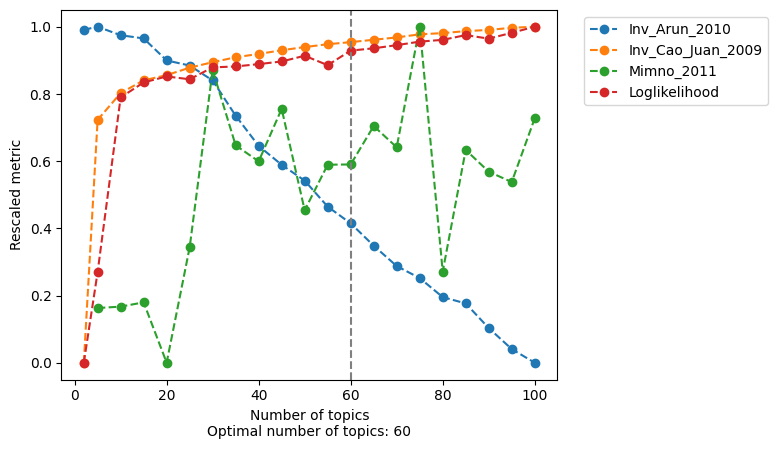

In [59]:
# Evaluate models
from pycisTopic.lda_models import *
model=evaluate_models(models,
                     select_model=60,
                     return_model=True,
                     metrics=['Arun_2010','Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'],
                     plot_metrics=False,
                     save='/mnt/sdb/qdang/meso_project/pycistopic/model_selection.pdf')

In [60]:
# Add model to cisTopicObject
cistopic_obj.add_LDA_model(model)

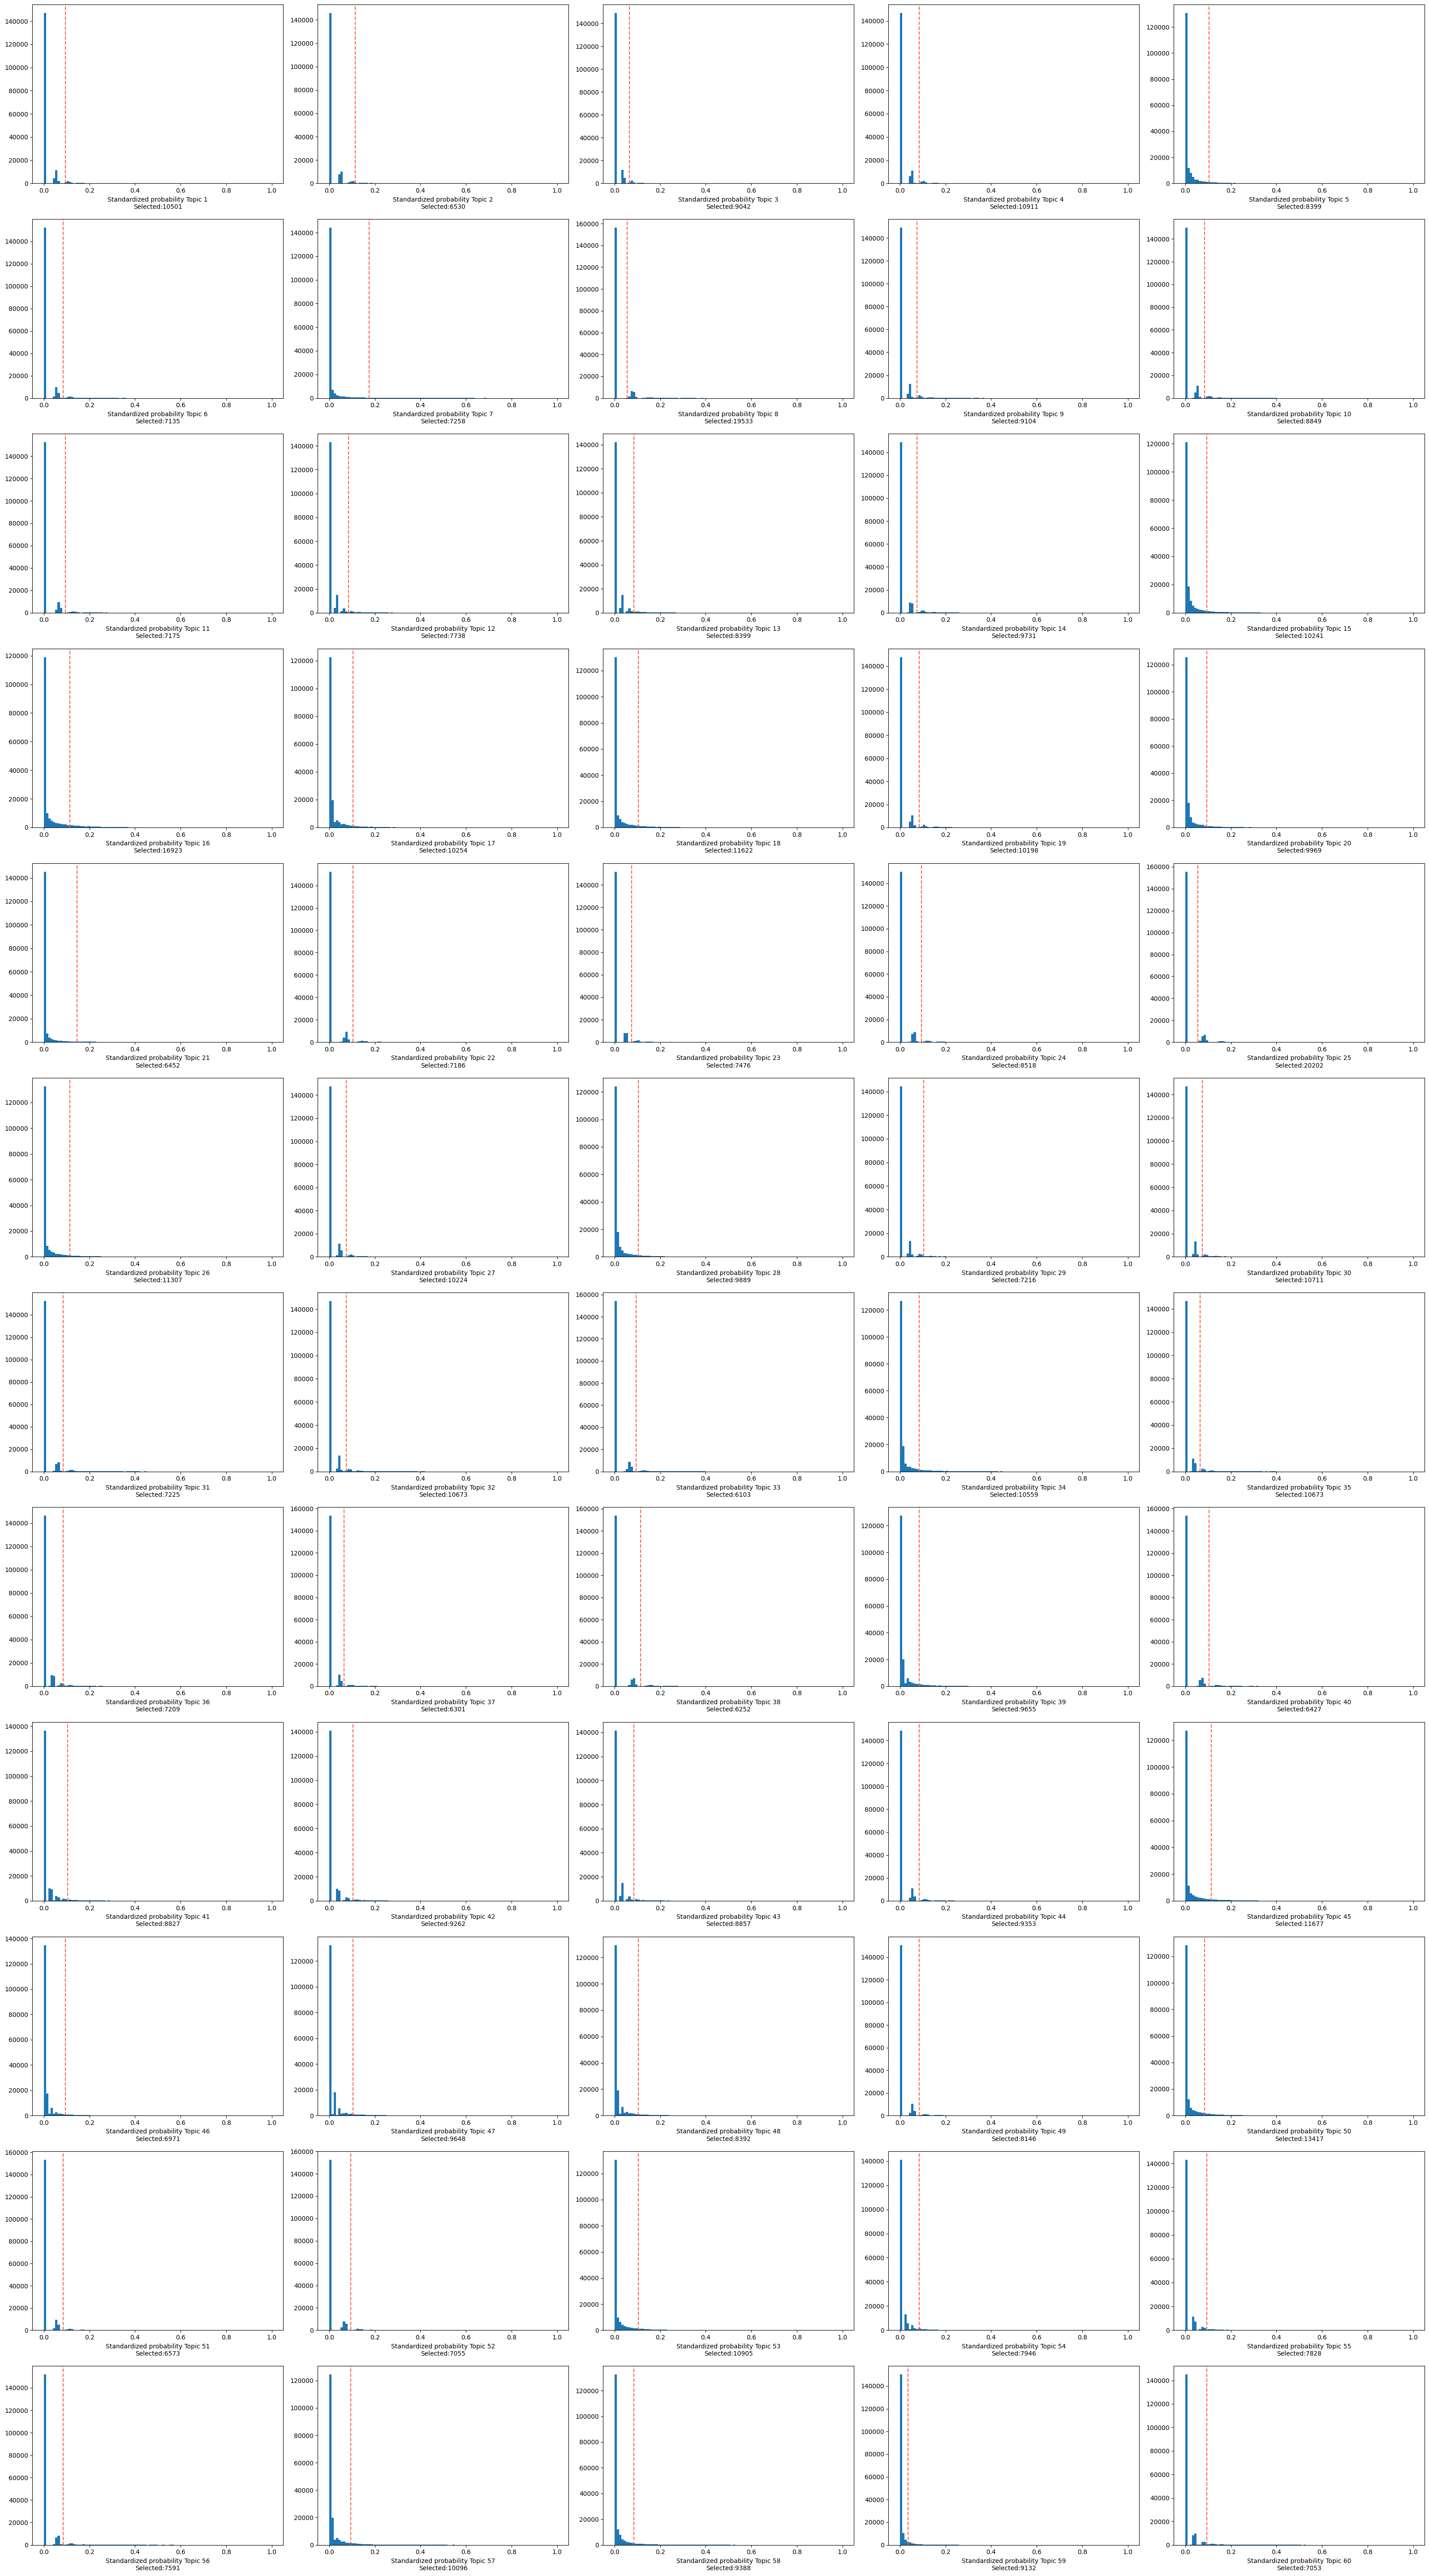

In [62]:
from pycisTopic.topic_binarization import *
region_bin_topics = binarize_topics(cistopic_obj, method='otsu', ntop=3000, plot=True, num_columns=5, save='/mnt/sdb/qdang/meso_project/pycistopic/topic_binarization/otsu.pdf')

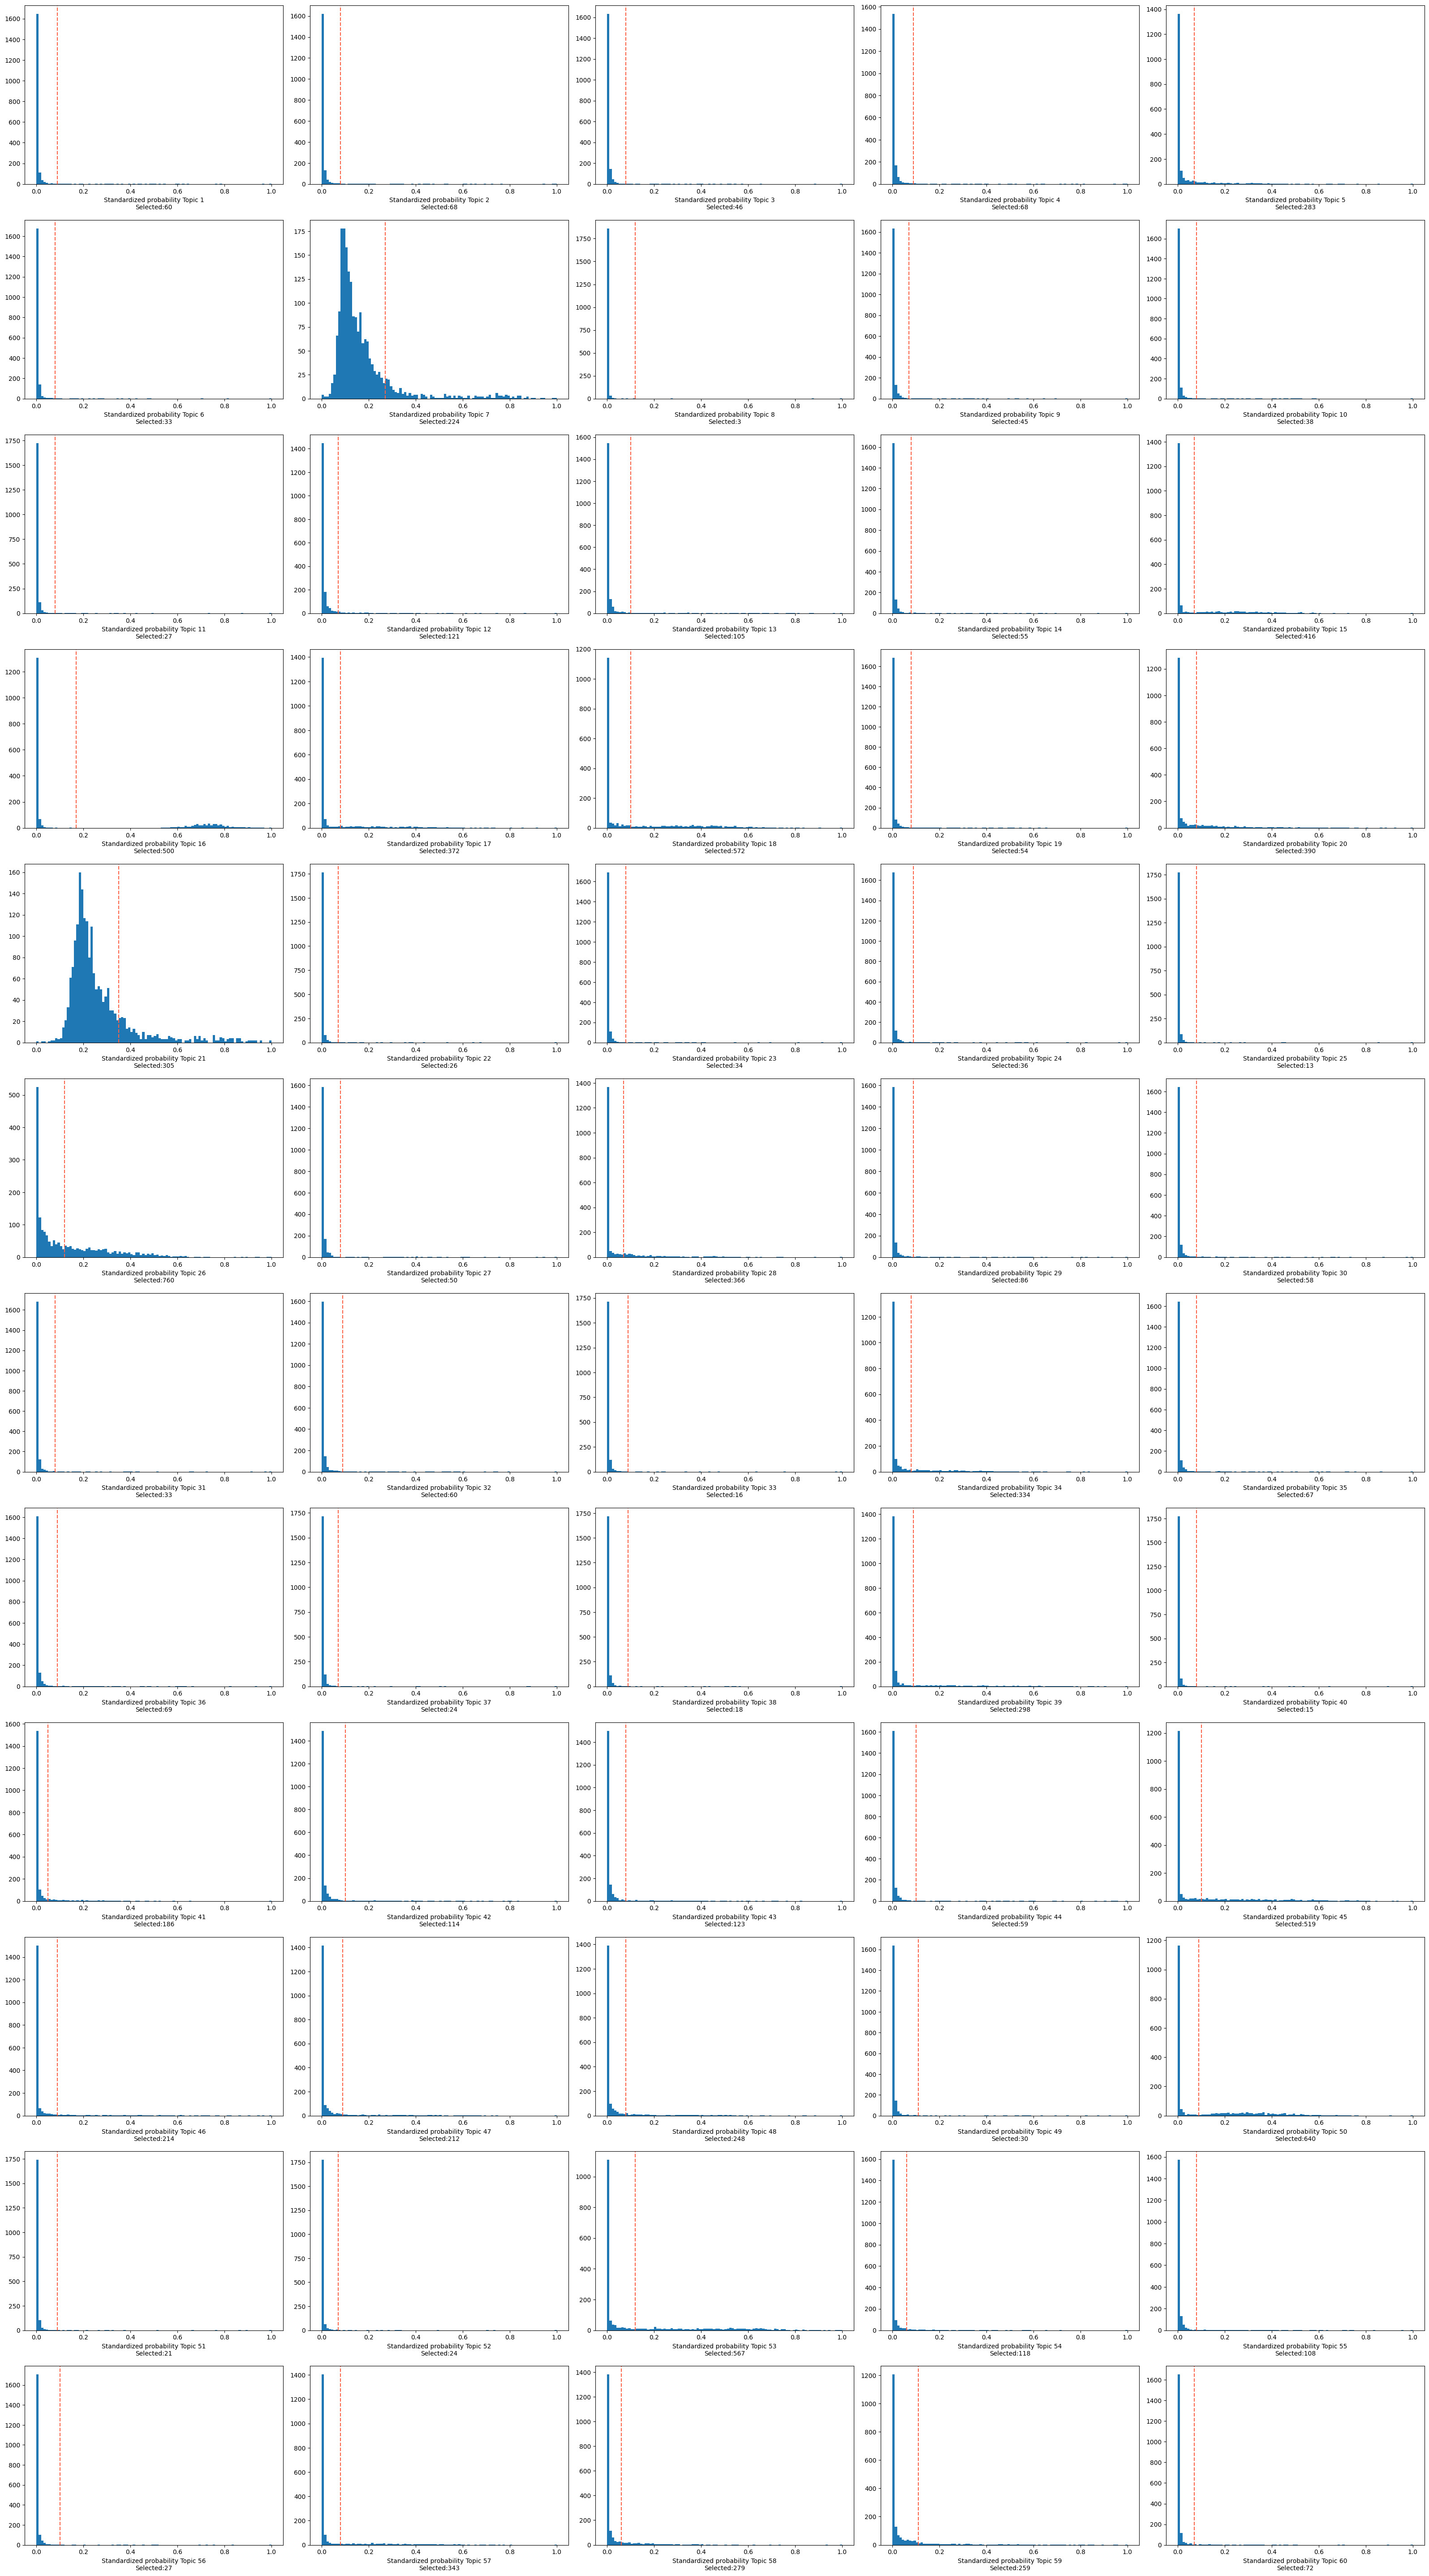

In [63]:
binarized_cell_topic = binarize_topics(cistopic_obj, target='cell', method='li', plot=True, num_columns=5, nbins=100)

In [64]:
from pycisTopic.topic_qc import *
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

In [65]:
topic_qc_metrics

,Log10_Assignments,Assignments,Regions_in_binarized_topic,Cells_in_binarized_topic,Coherence,Marginal_topic_dist,Gini_index
Topic1,4.732988,54074.0,10501,60,-2.410847,0.003765,0.727409
Topic2,4.756073,57026.0,6530,68,-2.595322,0.003964,0.724637
Topic3,4.673251,47125.0,9042,46,-3.228862,0.003292,0.695093
Topic4,4.731016,53829.0,10911,68,-3.281299,0.003748,0.722786
Topic5,5.203759,159867.0,8399,283,-1.792994,0.010912,0.752297
Topic6,4.571907,37317.0,7135,33,-3.350723,0.002629,0.665069
Topic7,6.555191,3590798.0,7258,224,-0.738053,0.242707,0.127950
Topic8,4.445371,27885.0,19533,3,-3.331478,0.001991,0.620096
Topic9,4.677388,47576.0,9104,45,-3.272769,0.003323,0.688608
Topic10,4.645786,44237.0,8849,38,-3.699909,0.003098,0.690080
